Code to simulate straining of the Fibre Bragg Grating  
Written by: Samhita S Sodhi

This notebook contains the _same code_ from newSimulatingCode_FBG.ipynb **BUT** is a scratch notebook to test code
last updated: 6 May 2024

In [1]:
import sys
sys.path.insert(0, ".")

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from funcs import *

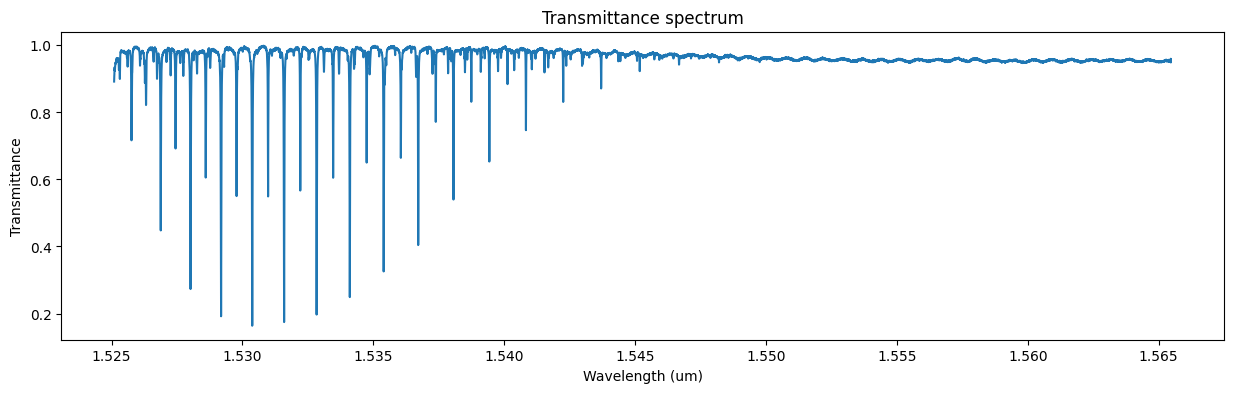

In [2]:
#Testing function using generated data from NASA PSG
spectra_wav, spectra_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/C2H2 gas cell-_40nm_1_T_C33-c2h2200C3M_42nm_0_T.txt', 0, 2, "\t", None, "nm", "dB")
plot_spectra(spectra_wav, spectra_data)

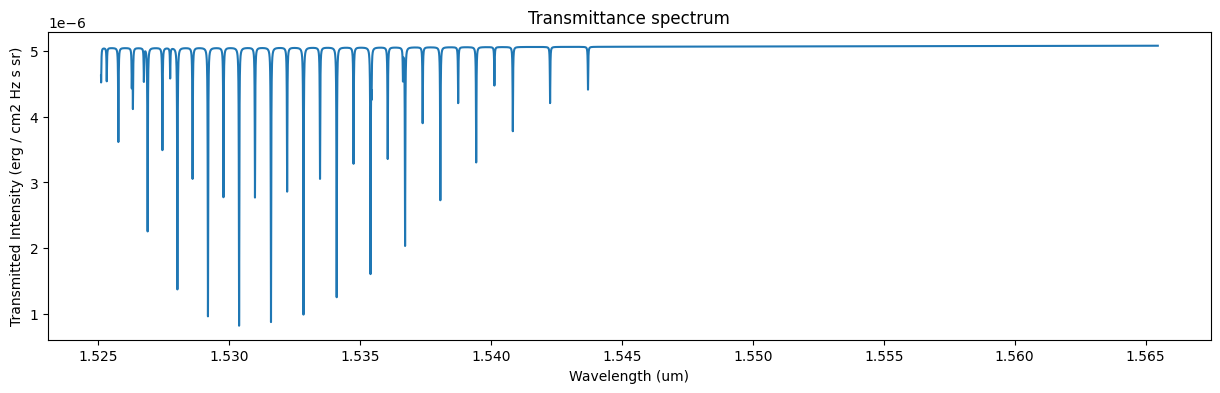

In [3]:
transmittance = fit_curves(spectra_wav, spectra_data, 0.09, 'lorentzian')
flux, transmitted_intensity = blackbodyabsorption(spectra_wav, transmittance, 3000)
plot_spectra(spectra_wav, transmitted_intensity, yaxislabel = 'Transmitted Intensity (erg / cm2 Hz s sr)')

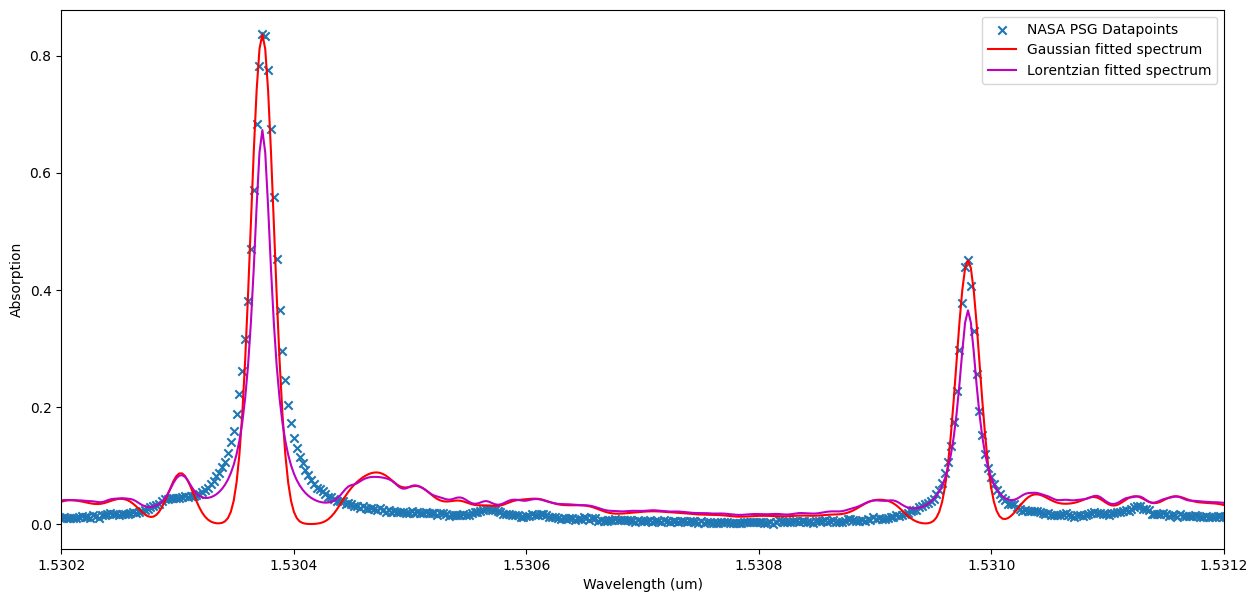

In [4]:
#testing to see whether the gaussian and lorentzian model fits the data better
#appears neither does so, may require a convolution of the two (Voigt model)

x_values = np.array(spectra_wav)
y_values = np.array(1.0 - spectra_data) #converting to absorption sepctrum so function can find peaks

peaks, properties  = find_peaks(y_values, height=0.000010, width = 0) #properties include, peak heights, peak widths, etc. 

# --- GAUSSIAN
def gaussian(x, sigma, mu, amp):
  return amp*1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2/(2*sigma**2))

peak = np.array(x_values[peaks]) #since peaks is an array of indexes, associating each index to it's wavelength value
widths = 0.00001
amps = np.array(properties['peak_heights']) #array of all the heights
# widths = np.array(properties['widths'])

x = np.array(spectra_wav)
y_g = np.zeros(x.shape) 

for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
    g = gaussian(x, sigma=widths, mu=peak[i], amp=amps[i]) #fit this gaussian
    y_g += g

scale = max(y_g)/max(properties['peak_heights'])
amps_scaled = np.array(properties['peak_heights']) / scale #array of all the heights

y_gscaled = np.zeros(x.shape) 

for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
    g = gaussian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i]) #fit this gaussian
    y_gscaled += g



# --- LORENTZIAN
def lorentzian(x, sigma, mu, amp):
    return (amp/np.pi) * (sigma/((x-mu)**2 + sigma**2))

y_l = np.zeros(x.shape) 

for i in range(len(peaks)):
    lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps[i])
    y_l += lor

scale_l = max(y_l)/max(properties['peak_heights'])
amps_scaled_l = np.array(properties['peak_heights']) / scale_l #array of all the heights

y_lscaled = np.zeros(x.shape) 

for i in range(len(peaks)):
    lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i])
    y_lscaled += lor

figure(figsize=(15, 7))
plt.scatter(x_values, y_values, marker = 'x')
plt.plot(x, y_gscaled, color = 'r')
plt.plot(x, y_lscaled, color = 'm')
plt.xlim([1.5302, 1.5312])
plt.xlabel('Wavelength (um)')
plt.ylabel('Absorption')
plt.legend(['NASA PSG Datapoints', 'Gaussian fitted spectrum', 'Lorentzian fitted spectrum'])
plt.show()

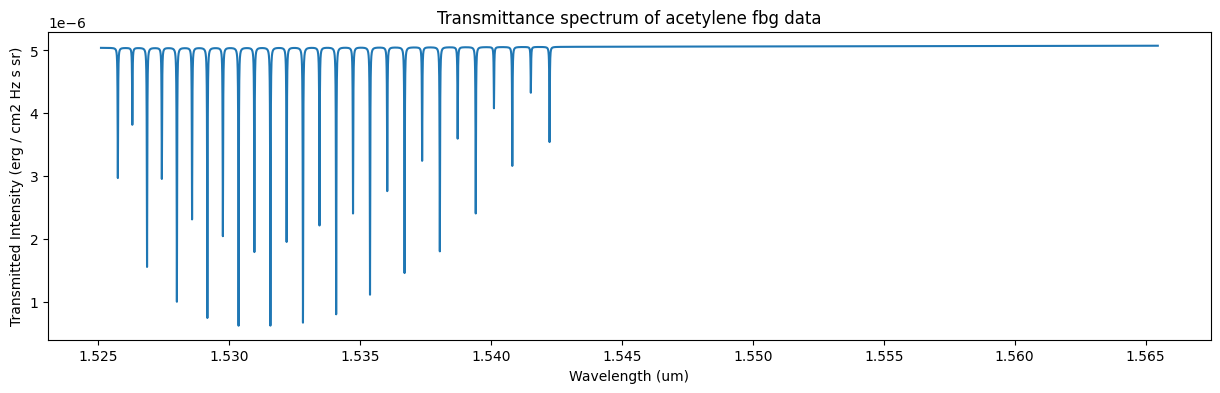

In [5]:
#Loading the fibre grating data for the simulation
fibre_wavelength, fibregrating_line_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/FBG_C33-c2h2200C3M_42nm_0_T.txt', 0, 2, '\t', None, "nm", "dB")
transmittanceFBG = fit_curves(fibre_wavelength, fibregrating_line_data, 0.09, 'lorentzian')
fluxFBG, transmitted_intensityFBG = blackbodyabsorption(fibre_wavelength, transmittanceFBG, 3000)
plot_spectra(spectra_wav, transmitted_intensityFBG, title = 'Transmittance spectrum of acetylene fbg data', yaxislabel = 'Transmitted Intensity (erg / cm2 Hz s sr)')

In [6]:
fibre_wavelength_new, interpolatedvals = apply_strain(0.0005, [spectra_wav, fibre_wavelength], [transmitted_intensity, transmitted_intensityFBG], 0, 0.55e-6, 8.6e-6, 0.22) #values for silica, no temperature change

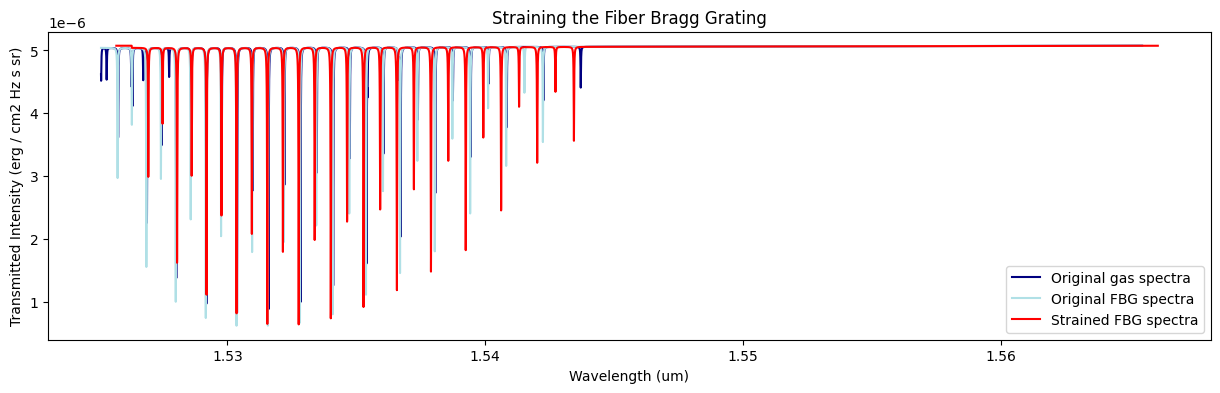

In [7]:
plot_strainspectra([spectra_wav, fibre_wavelength, fibre_wavelength_new], [transmitted_intensity, transmitted_intensityFBG, interpolatedvals])

In [8]:
# def correlation():
#     """
#     For different input values of strain this function plots the amount of total, transmitted and reflected light once incident light
#     passes through the fibre bragg grating.

#     Parameters include: 
#     - strainvalues  : user inputs values of strain i.e., strain = np.linspace(0, 0.0014, 500) for which the stretching of the fibre bragg 
#                       grating is simulated
#     - normalisation : user can choose whether to normalise the calculations to see the outputs as a fraction rather than true values else 
#                       default is 'True'. 
#     """
#     # ~~~~~ Finding the overall effect of straining the fibre - original code
#     # For transmitted light
#     # strainedtransmittedlight = np.array(1-interpolatedvals*spectra_data) #multiplying the interpolatedvalues FBG data with original gas data
#     # trans = np.sum(strainedtransmittedlight)
    
#     # For reflected light
#     # strainedreflectedlight = np.array(interpolatedvals*spectra_data) 
#     # refl = np.sum(strainedreflectedlight)

#     # print('Total Transmitted Light (erg / cm2 Hz s sr):', trans) 
#     # print('Total Reflected Light (erg / cm2 Hz s sr):', refl) 
#     # print('Incident Light (erg / cm2 Hz s sr):', trans + refl) 


#     # ~~~~~ Alison code 
#     # reflectedvals = []
#     # transmittedvals = []

#     # # for i in np.linspace(3.5e-4, 6e-4, 3):
#     # for i in [4.8e-4, 6.5e-4]:
#     #     fibre_wavelength_new, interpolatedvals = visualise_strain('acetylene gas', i, 0, 0.55e-6, 8.6e-6, 0.22) #values for silica, no temperature change
#     #     reflectedvals.append(reflected)
#     #     transmittedvals.append(transmitted)

#     # plt.plot(reflectedvals)
#     # plt.plot(transmittedvals)
#     # plt.plot(reflectedvals+transmittedvals)
#     # plt.show()


#     # ~~~~~ New code 
#     reflectedvals = []
#     transmittedvals = []
#     array_lengths = []

#     # for i in np.linspace(3.5e-4, 6e-4, 10):
#     for i in np.linspace(1e-5, 8e-3, 100):
#         fibre_wavelength_new, interpolatedvals = apply_strain(i, 0, 0.55e-6, 8.6e-6, 0.22) #values for silica, no temperature change
#         reflected = np.array(interpolatedvals*spectra_data).sum()
#         total = 5e-6*np.ones(len(interpolatedvals*spectra_data))
#         transmitted = (total-interpolatedvals*spectra_data).sum()
#         reflectedvals.append(reflected)
#         transmittedvals.append(transmitted)
#         array_lengths.append(len(interpolatedvals*spectra_data))

#     figure(figsize=(10, 10))
#     plt.subplot(4, 1, 1)
#     plt.plot(reflectedvals, label = 'r')
#     plt.subplot(4, 1, 2)
#     plt.plot(transmittedvals, label = 't')
#     plt.subplot(4, 1, 3)
#     plt.plot(reflectedvals+transmittedvals, label = 'total')
#     plt.subplot(4, 1, 4)
#     plt.plot(array_lengths)
#     plt.legend()
#     plt.show()

#     # print(reflectedvals)
#     # print(transmittedvals)
#     # print(reflectedvals + transmittedvals)
#     # print(array_lengths)

#     return 

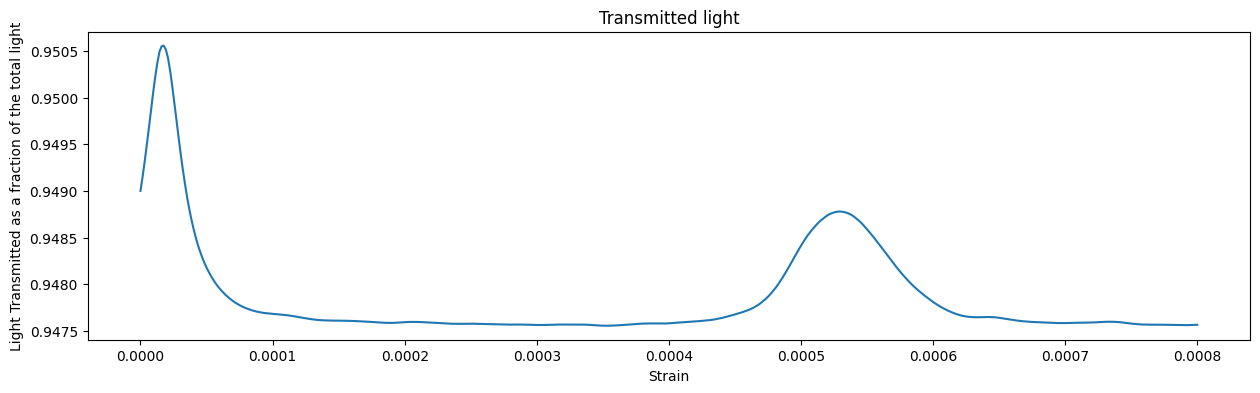

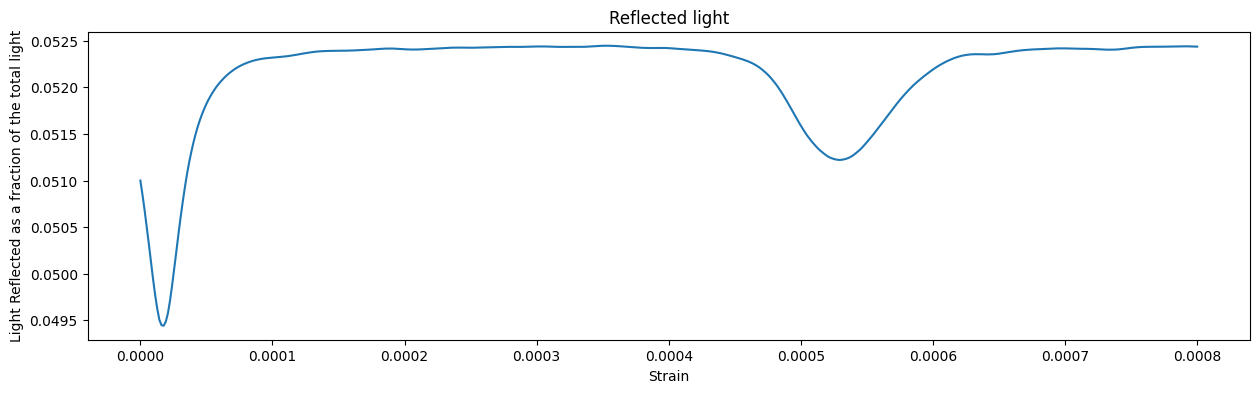

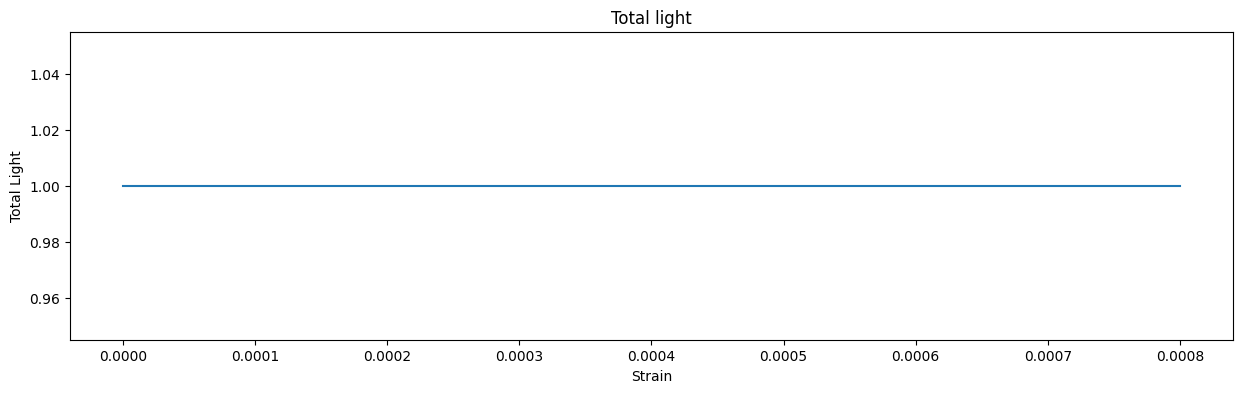

In [9]:
# Transmitted/reflected light for different strain values
# strain = np.linspace(0, 0.0008, 500) # takes a long time to run, else conversion to photoncounts does not work - wav, data different sizes! 
# transmittedlight, reflectedlight = correlation(strain, [spectra_wav, fibre_wavelength], spectra_data, [transmitted_intensity, transmitted_intensityFBG], 'False')

# totallight = np.array(transmittedlight) + np.array(reflectedlight)
# print(totallight[0])


# Normalised transmitted/reflected light for different strain values 
strain = np.linspace(0, 0.0008, 500)
transmittedlightNorm, reflectedlightNorm = correlation(strain, [spectra_wav, fibre_wavelength], spectra_data, [transmitted_intensity, transmitted_intensityFBG], 'True')

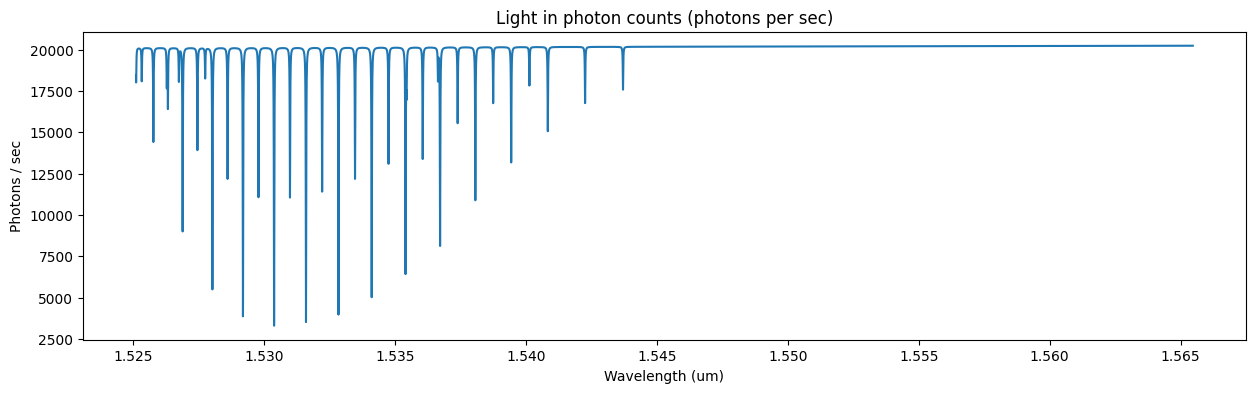

In [10]:
#testing unit conversion function
photoncount_persec = convert_fluxunits_to_photoncounts(spectra_wav, transmitted_intensity, 0.35, 0.000000503, 0.045, None, None)